In [1]:
import ast
import pandas as pd
import numpy as np
import time
import os, sys, glob
import re
from ast import literal_eval
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
from IPython.display import display

pd.set_option('display.max_colwidth', -1)
from collections import Counter
from gensim.corpora.dictionary import Dictionary
import gensim
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

/home/mimi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read data from google cloud storage

In [2]:
#read files
def read_gs(path, id_name):
    dev_file = tf.gfile.Glob(path)[0]
    df = pd.read_csv(tf.gfile.Open(dev_file, mode='rb'), 
                     escapechar='\\', 
                     error_bad_lines=False, 
                     header=0, 
                     dtype={'original_id': str})
    df.rename(columns={'original_id': id_name}, inplace=True)
    
    return df

path = 'gs://directory/'
shop_dir = path + '/*.csv'
shopDf = read_gs(shop_dir, "shop_id")

# Data Preprocessing

In [3]:
#replace column with another column according to condition given
shopDf = shopDf[shopDf['tags_th'] != "['null']"]
shopDf['tags_th'] = np.where(shopDf['tags_th'] == '[]', shopDf['tags_en'], shopDf['tags_th'])
shopDf['title_th'] = np.where(shopDf['title_th'].isnull(), shopDf['title_en'], shopDf['title_th'])

tags_en = shopDf['tags_en']
tags_th = shopDf['tags_th']

def literal(i):
    return literal_eval(i.replace("['","[\"").replace("']", "\"]").replace("','", "\",\""))

tags = tags_th.map(literal)
print (len(tags))

7799


In [4]:
def doc_lens(doc):
    
    document_lengths = np.array(list(map(len, doc)))
    print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
    print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
    print("The maximum number of words in a document is: {}.".format(max(document_lengths)))
    
    return document_lengths

In [5]:
document_lengths = doc_lens(tags)
shorten_length = 30
print("There are {} documents with over {} words.".format(sum(document_lengths > shorten_length), shorten_length))
shorter_documents = document_lengths[document_lengths <= shorten_length]

The average number of words in a document is: 8.793947942043852.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 44.
There are 22 documents with over 30 words.


In [6]:
percent = 0.05
flatten = lambda l : [item for sublist in l for item in sublist]
words = flatten(tags)
totalword = len(words)
word_percent = round(percent * totalword)
print (word_percent)
most_common = Counter(words).most_common(word_percent)
# print ('Top ten common words are ... \n {}'.format(dict(most_common)))
least_common = Counter(words).most_common()[:-word_percent-1:-1]
# print ('\nTop ten unique words are ... \n {}'.format(dict(least_common)))

3429


### Remove word that ends with s
#### Don't want to apply stemming and lematization because it effects shop's name

In [7]:
def filter_word(documents):
#     pattern_s = "([^e+u+s\s])s$"
    pattern_s = "([^s\s])s$"
    for i in documents:
        for j, item in enumerate(i):
            item = item.lower()
            if re.search(re.compile(pattern_s), item) != None:
                item = item[:-1]
            i[j] = item

    return documents

tags = filter_word(tags)

### Tokenize the text using nltk's word tokenize

In [8]:
import nltk
nltk.download('punkt')

documents = []
for tag in tags:
    g = []
    for word in tag:
        #Tokenize a string to split off punctuation other than periods
        words = nltk.word_tokenize(word)
        for current_word in words:
            current_word = current_word.lower()
            g.append(current_word)
    documents.append(g)

[nltk_data] Downloading package punkt to /home/mimi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
document_lengths = doc_lens(documents)

The average number of words in a document is: 9.357866393127324.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 52.


/home/mimi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


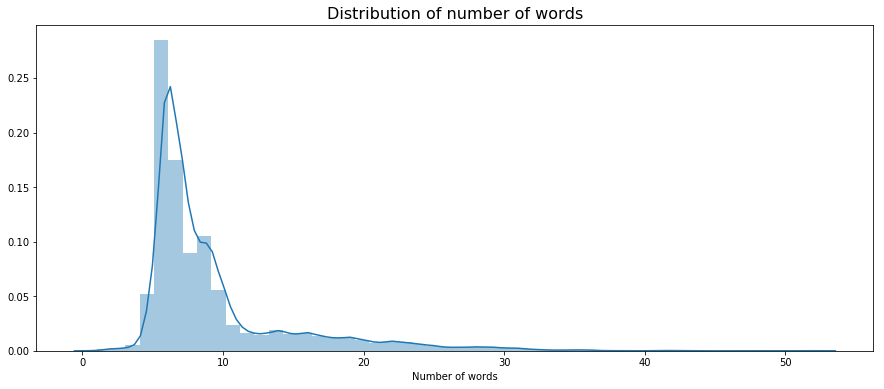

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [11]:
exclude_len = 30
print("There are {} documents with over {} words.".format(sum(document_lengths > exclude_len), exclude_len))

There are 61 documents with over 30 words.


/home/mimi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


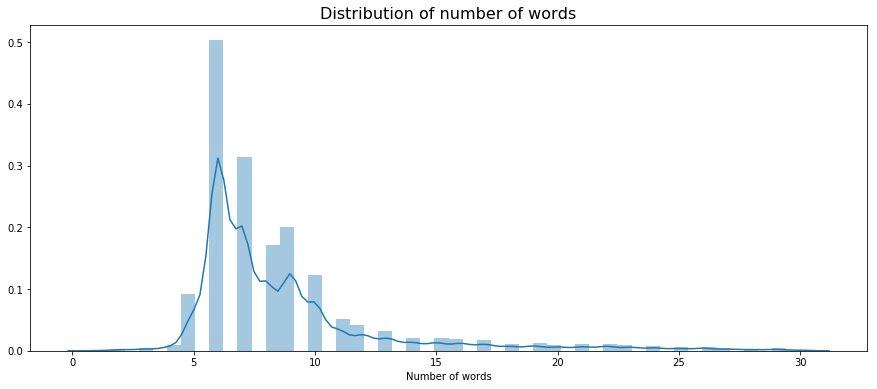

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents);

# Show two-word document
The shorter documents will probably be harder to classify since we'll have less words to cling to. LDA for example tries to find topics in documents, but if the documents are so short, perhaps it will find it hard to really find a topic in a two-word document.

In [13]:
[i for i in documents if len(i) <= 2]

[['kanchanaburi', 'กาญจนบุรี'],
 ['phuket', 'ภูเก็ต'],
 ['ซีคอน', 'บางแค'],
 ['ยโสธร', 'ร้านอาหาร'],
 ['chiangmai', 'เชียงใหม่'],
 ['สนามบินสมุย', 'สมุย'],
 ['ฟรีเมนูเซ็ต', 'สนามบิน'],
 ['ฟรีเมนูเซ็ต', 'สนามบิน'],
 ['คิงเพาเวอร์ออนไลน์', 'ช้อปปิ้งออนไลน์'],
 ['กันและกัน2017'],
 ['buddhamonthon', 'พุทธมณฑล'],
 ['kamphaengphet', 'กำแพงเพชร'],
 ['เคลือบแก้ว'],
 ['truebonu', 'ทรูโบนัส'],
 ['สนามบินสมุย', 'สมุย'],
 ['tak', 'ตาก']]

## Plot total number of words

72982
5130


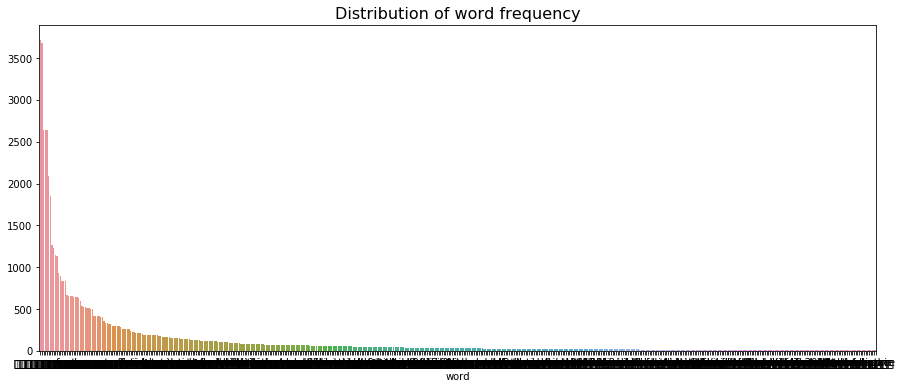

In [14]:
allword = flatten(documents)
print (len(allword))
print (len(set(allword)))
word = 500
most_common = Counter(allword).most_common(word)
least_common = Counter(allword).most_common()[-word-1:-1]
x = [i[0] for i in most_common]
y = [i[1] for i in most_common]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of word frequency", fontsize=16)
ax.set_xlabel("word")
sns.barplot(x,y)
# most_common

In [54]:
most_common[:5]

[('ร้านอาหาร', 3714),
 ('กินข้าว', 3679),
 ('ช้อปปิ้ง', 2639),
 ('ซื้อของ', 2637),
 ('ร้านค้า', 2637)]

# From above chart, we choose more than 3 frequency of word

In [16]:
from collections import defaultdict

frequency = defaultdict(int)
for text in documents:
    for token in text:
        frequency[token] += 1
        
documents1 = [[token for token in text if frequency[token] >= 3 ] for text in documents]
flat_doc1 = flatten(documents1)
print ('Lenghts of total word {}'.format(len(flat_doc1)))
print ('Lengths unique word {}'.format(len(set(flat_doc1))))

Lenghts of total word 68302
Lengths unique word 1092


# Remove word less than 3 

In [17]:
import nltk
nltk.download('punkt')

documents_cha = []
for tag in documents:
    g = []
    for word in tag:
        if len(word) >= 3 or word == "ยา" or word == "ชา":
            g.append(word)
    documents_cha.append(g)

[nltk_data] Downloading package punkt to /home/mimi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
from collections import defaultdict

frequency = defaultdict(int)
for text in documents_cha:
    for token in text:
        frequency[token] += 1
        
documents_freq = [[token for token in text if frequency[token] >= 3] for text in documents_cha]

flat_doc1 = flatten(documents_freq)
print ('Lenghts of total word {}'.format(len(flat_doc1)))
print ('Lengths unique word {}'.format(len(set(flat_doc1))))

Lenghts of total word 67343
Lengths unique word 1039


Remove unwanted word those are Thailand province, district, and road in both Thai and English that are contained in the documents.

In [19]:
province = np.load('province.npy')
print (len(province))
district = np.load('district.npy')
road = np.load('road.npy')
exclude_word = list(province) + list(district) + list(road)

265


## Create Dictionary and Corpus needed for LDA -Topic Modeling

Dictionary is a unique id for each word in the document.

Corpus is a mapping of (word_id, word_frequency).

Remove exclude from dictionary

In [20]:
#Create Dictionary
dictionary = Dictionary.from_documents(documents_freq)
# ignore words that appear in less than 3 documents or more than 80% documents
dictionary.filter_extremes(no_below=3, no_above=0.9)
dictionary.compactify()
# remove exclude word from dictionary 
del_ids = [k for k,v in dictionary.items() if v in exclude_word]
dictionary.filter_tokens(bad_ids=del_ids)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Visualize the cleansed words frequencies

In [21]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)
cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
cleansed_words_df.drop(['id'], axis=1, inplace=True)
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [22]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)
    
    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [23]:
cleansed_words_df.head()

,count
ร้านอาหาร,3711
กินข้าว,3678
ช้อปปิ้ง,2639
ซื้อของ,2637
ร้านค้า,2637


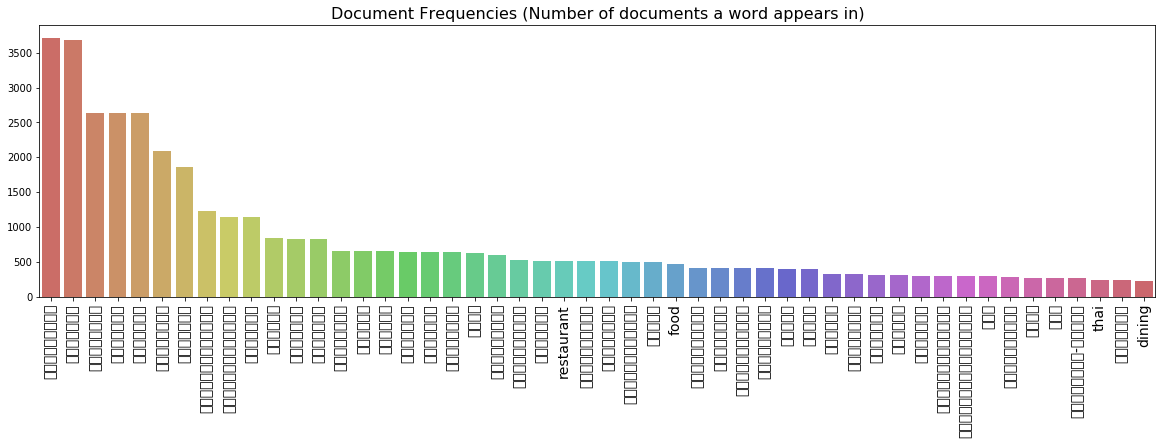

In [24]:
import warnings
warnings.filterwarnings('ignore')

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

## Tf-idf score
Tf-idf reflects how important a word is to a document in a collection or corpus.

The higher the Tf-idf score (weight), the rarer the term and vice versa.

In [25]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
low_value = 0.1
low_value_words = []
for bow in corpus:
    low_value_words += [id for id, value in tfidf_model[bow] if value < low_value]

#filter value tfidf > 0.9 (unique words that we don't want to feed in LDA)
dictionary.filter_tokens(bad_ids=low_value_words)
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Building LDA Model
In addition to the corpus and dictionary, you need to provide the number of topics as well.
LDA model is built with 5 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

The weights reflect how important a keyword is to that topic.

# Find the optimal number of topics for LDA
Build many LDA models with different values of number of topics and pick the one that gives the highest coherence value.

In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model= gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                           num_topics=num_topics,  
                                           id2word=dictionary,
                                            )
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Plot coherence score to choose the best number of topics

Plotting graph


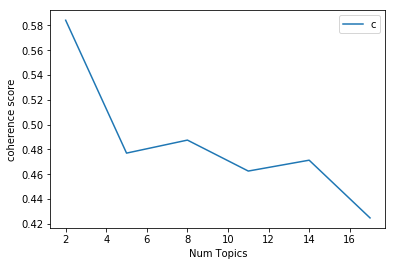

Num Topics = 2  has Coherence Value of 0.5842
Num Topics = 5  has Coherence Value of 0.4771
Num Topics = 8  has Coherence Value of 0.4876
Num Topics = 11  has Coherence Value of 0.4626
Num Topics = 14  has Coherence Value of 0.4714
Num Topics = 17  has Coherence Value of 0.4248


In [44]:
start=2
limit=20
step=3
corpus = corpus
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                        texts=documents, start=start, limit=limit, step=step)
# Print the coherence scores
print ('Plotting graph')
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    round_cv = round(cv, 4)
    print("Num Topics =", m, " has Coherence Value of", round_cv)

# Choose number of topic that have the best coherence score 

In [45]:
import gensim
from gensim.test.utils import datapath

optimal_model = gensim.models.ldamodel.LdaModel.load("lda.model")

In [46]:
optimal_model = model_list[2]
#save model
optimal_model.save('lda.model')

model_topics = optimal_model.show_topics(formatted=False)
topics = optimal_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.053*"เค้ก" + 0.050*"เบเกอรี่" + 0.050*"ขนมปัง" + 0.043*"แต่งรถ" + 0.042*"ตกแต่งรถ" + 0.027*"อาหารญี่ปุ่น" + 0.025*"ปิ้งย่าง" + 0.024*"บาร์บีคิว" + 0.023*"ยากินิกุ" + 0.022*"japanese" + 0.019*"noodle" + 0.018*"brand" + 0.018*"อิ่มนานาชาติ2018" + 0.017*"dining" + 0.016*"eating" + 0.016*"อิ่มญี่ปุ่นปี5" + 0.014*"leading" + 0.013*"ซูชิ" + 0.013*"dinning" + 0.013*"ฟาสต์ฟู้ด"')
(1, '0.071*"coffee" + 0.044*"ฟิวชั่น" + 0.038*"cafe" + 0.031*"ศูนย์บริการ" + 0.030*"ดูแลรถ" + 0.027*"เครื่องหนัง" + 0.024*"beverage" + 0.022*"drink" + 0.020*"ร้านกาแฟ" + 0.020*"คาเฟ่" + 0.015*"beautygenyz" + 0.015*"beauty" + 0.015*"bean" + 0.015*"bakery" + 0.015*"best" + 0.014*"look" + 0.014*"your" + 0.014*"dessert" + 0.013*"online" + 0.013*"eating"')
(2, '0.106*"ของหวาน" + 0.103*"ขนม" + 0.099*"ของกินเล่น" + 0.064*"เครื่องประดับ" + 0.064*"ตกแต่ง" + 0.039*"ชาบู" + 0.039*"สุกี้" + 0.038*"สุกี้ยากี้" + 0.034*"ร้านค้าออนไลน์" + 0.022*"online" + 0.018*"ถ่ายภาพ" + 0.018*"กล้อง" + 0.018*"กล้องถ่ายรูป" + 0.012*"dessert

# Compute Model Perplexity and Coherance Score
The higher coherance Score, the better model.

In [47]:
model=optimal_model
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.426394814616919

Coherence Score:  0.48757922882874766


# Visualize the topics keywords
A good topic model should have non-overlapping cluster.

In [48]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(lda_display)

# Merge LDA result back to dataframe 

In [49]:
shopDf['group'] = [max(model[i], key=lambda x:x[1])[0] for i in corpus]
shopDf['prob'] = [max(model[i], key=lambda x:x[1])[1] for i in corpus]
shopDf['tags_other'] = [max(model[i], key=lambda x:x[1])[0] if (max(model[i], key=lambda x:x[1])[1] > 0.6) else 99 for i in corpus ]

In [51]:
def result(tag_group, column, shopDf):
    
    result = shopDf[shopDf[column] == tag_group][['merchant_id', 'title_th', 'tags_th']]
    print ('Number of result is...\n{}'.format(result.count()))
    
    return result

In [53]:
res = result(0, 'tags_other', shopDf)
res.head()

Number of result is...
merchant_id    283
title_th       283
tags_th        283
dtype: int64


,merchant_id,title_th,tags_th
120,KXxRyyO6ne1M,ตองหนึ่ง เจริญมอเตอร์ (จ.เชียงใหม่),"['ชั้นนำ','ช้อปปิ้ง','ซื้อของ','ตกแต่งรถ','รถยนต์','ร้านค้า','ร้านค้าแบรนด์','ร้านดัง','เชียงใหม่','แต่งรถ']"
140,Np0xbb0RZWqp,แปดซีฟู๊ด,"['กรุงเทพมหานคร','กินข้าว','บาร์บีคิว','ปิ้งย่าง','ยากินิกุ','ร้านอาหาร','อาหารนานาชาติ']"
145,q3beggZGlqJo,หอมฟุ้ง ชาบู ปิ้ง ย่าง นครชัยศรี (จ.นครปฐม),"['กินข้าว','ข้าวปั้น','ซาชิมิ','ซูชิ','นครปฐม','บาร์บีคิว','ปลาดิบ','ปิ้งย่าง','ยากินิกุ','ร้านอาหาร','อาหารไทย']"
153,PDKrOOQPNO1g,มีดี มอเตอร์ (จ.พะเยา),"['ช้อปปิ้ง','ซื้อของ','ตกแต่งรถ','ตลาดนัด','พะเยา','รถยนต์','ร้านค้า','แต่งรถ']"
195,ZjN0llPao7Z5,ออเรนจ์ คาร์แคร์,"['กรุงเทพมหานคร','ช้อปปิ้ง','ซื้อของ','ตกแต่งรถ','ตลาดนัด','รถยนต์','ร้านค้า','แต่งรถ']"
